# Wasserstein Pareto Frontier Experiment on CRIME Data Set

## Import Data
The experiment used the CRIME data set as in "Fair Regression with Wasserstein Barycenters" by Chzhen and etc. for comparison purpose: https://archive.ics.uci.edu/ml/datasets/communities+and+crime

In [53]:
import os
import ot
import math
import tempfile
import six.moves.urllib as urllib
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from scipy.linalg import sqrtm
from scipy import stats
from scipy.io import loadmat
from time import perf_counter
from tabulate import tabulate

# import data
path =r'/Users/shizhouxu/Documents/LIBRARY/Python/Fair_L2_Supervised_Learning/Communities-Crime/' # use your path
attrib = pd.read_csv(path + 'attributes.csv', delim_whitespace = True)
data = pd.read_csv(path + 'communities.data', names = attrib['attributes'])
data = data.drop(columns=['state','county','community','communityname','fold'], axis=1)
data = data.replace('?', np.nan)
feat_miss = data.columns[data.isnull().any()]
# clearning up the "Nan" in data
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(data[['OtherPerCap']])
data[['OtherPerCap']] = imputer.transform(data[['OtherPerCap']])
data = data.dropna(axis=1)
# following "Fair Regression with Wasserstein Barycenters", we made the sensitive variable (race) binary for comparison purpose
# binary variable that indicating dominance of black race population in the community: brate_binary
brate = data['racepctblack']
np.unique(brate)
brate_binary = np.zeros(len(brate))

for i in range(0,len(brate)):
    brate_binary[i] = (brate[i] >= 0.3)*1
    
# independnet variable without race features (which are linearly dependnet of brate_binary): X_d
X_d = np.array(data.drop(['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'ViolentCrimesPerPop'],axis = 1))
# independnet variable that is a direct sum of X_d and brate_binary: X
X = np.concatenate((X_d,brate_binary[...,np.newaxis]),axis = 1)
# dependnet variable: Y
Y = np.array(data['ViolentCrimesPerPop'])

# split the dependent and independent data into train and test data sets
trainX_list = []
trainy_list = []
testX_list = []
testy_list = []

for i in range(0,5):
    trainX, testX, trainy, testy = train_test_split(X, Y, test_size=0.5, random_state=i)
    trainX_list.append(trainX)
    testX_list.append(testX)
    trainy_list.append(trainy)
    testy_list.append(testy)

## Compute the Fair Data Representation (Wasserstein Pseudo-barycenter Pair)

In [72]:
# Compute the Wasserstein pseudo-barycenter for X
t = perf_counter() # time recording

# mean and covariance of X w/o sensitive variable and Y: X_d_mean, X_d_cov, Y_mean, Y_cov
X_d_mean = np.mean(X_d,axis = 0)
X_d_cov = np.cov(X_d.T)
Y_mean = np.mean(Y)
Y_cov = np.cov(Y.T)

# marginal/conditional variable, mean, and covariance: X(Y)_A(C)_mean(cov)
X_A = X_d[X[:,96] == 0,:]
Y_A = Y[X[:,96] == 0]
X_C = X_d[X[:,96] == 1,:]
Y_C = Y[X[:,96] == 1]

X_A_mean = np.average(X_A, axis = 0)
Y_A_mean = np.average(Y_A)
X_C_mean = np.average(X_C, axis = 0)
Y_C_mean = np.average(Y_C)

X_A_cov = np.cov(X_A.T)
Y_A_cov = np.cov(Y_A.T)
X_C_cov = np.cov(X_C.T)
Y_C_cov = np.cov(Y_C.T)

# cross-covariance (matrix) between Y and X: yX_A(C)_cov
yX_A_cov = np.cov(Y_A.T, X_A.T)[range(1, 1 + len(X_d[0,:])),0]
yX_C_cov = np.cov(Y_C.T, X_C.T)[range(1, 1 + len(X_d[0,:])),0]

# algorithm 1, step 1: iterative process to the independent barycenter covariance matrix with stop cirterion error equals 0.001
sample_size = len(X_d[:,0]) 
X_bar = np.random.rand(len(X_d[0,:]),len(X_d[0,:])) # random initialization for the covariance
eps = 10 # initialization for the stop variable

while eps > 0.001:
    X_new = ((len(X_A[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_A_cov@sqrtm(X_bar))) + ((len(X_C[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_C_cov@sqrtm(X_bar)))
    eps = np.linalg.norm(X_bar - X_new)
    X_bar = X_new
    
# algorithm 1, step 2: the corresponding Brenier's map for marginals of X: T_X_A(C)
T_X_A = np.linalg.inv(sqrtm(X_A_cov)) @ sqrtm( sqrtm(X_A_cov) @ X_bar @ sqrtm(X_A_cov) ) @ np.linalg.inv(sqrtm(X_A_cov))
T_X_C = np.linalg.inv(sqrtm(X_C_cov)) @ sqrtm( sqrtm(X_C_cov) @ X_bar @ sqrtm(X_C_cov) ) @ np.linalg.inv(sqrtm(X_C_cov))

# wasserstein pseudo-barycenter for X separated in train/test categories: X_TrainFairList, X_TestFairList
X_TrainFairList = []
X_TestFairList = []

X_fair = np.zeros(X_d.shape)
X_fair[X[:,96] == 0,:] = (X_d[X[:,96] == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
X_fair[X[:,96] == 1,:] = (X_d[X[:,96] == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean

for i in range(0,len(trainX_list)):
    trainX, testX, trainy, testy = train_test_split(X_fair, Y, test_size=0.5, random_state=i)
    X_TrainFairList.append(trainX)
    X_TestFairList.append(testX)

# Compute the Wasserstein Pseudo-barycenter for E(Y|X)

# marginal/conditional X_fair: X_fair_A(C)
X_fair_A = X_fair[X[:,96] == 0,:]
X_fair_C = X_fair[X[:,96] == 1,:]

# mean and covariance of marginal/conditional X_fair: X_fair_A(C)_mean(cov)
X_fair_A_mean = np.average(X_fair_A, axis = 0)
X_fair_C_mean = np.average(X_fair_C, axis = 0)
X_fair_A_cov = np.cov(X_fair_A.T)
X_fair_C_cov = np.cov(X_fair_C.T)

# cross-covariance between Y and X_fair: yX_fair_A(C)_cov
yX_fair_A_cov = np.cov(Y_A.T, X_fair_A.T)[range(1,1 + len(X_d[0,:])),0]
yX_fair_C_cov = np.cov(Y_C.T, X_fair_C.T)[range(1,1 + len(X_d[0,:])),0]

# covariance of marginal E(Y|X) in Gaussian case: yoX_A(C)_cov
# which is also the optimal linear estimation of covariance of E(Y|X) in general distribution case
yoX_A_cov = yX_fair_A_cov@np.linalg.inv(X_fair_A_cov)@yX_fair_A_cov.T
yoX_C_cov = yX_fair_C_cov@np.linalg.inv(X_fair_C_cov)@yX_fair_C_cov.T

# algorithm 2, step 1: iterative process to the dependent barycenter covariance matrix with stop cirterion error equals 0.00000000001
Y_bar = np.random.rand()
eps = 10
while eps > 0.00000000001:
    Y_new = ((len(X_A[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_A_cov*np.sqrt(Y_bar))) + ((len(X_C[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_C_cov*np.sqrt(Y_bar)))
    eps = Y_bar - Y_new
    Y_bar = Y_new

# algorithm 2, step 2: the corresponding Brenier's map for marginals of E(Y|X): T_Y_A(C)
T_Y_A = (1/np.sqrt(yoX_A_cov)) * np.sqrt( np.sqrt(yoX_A_cov) * Y_bar * np.sqrt(yoX_A_cov) ) * (1/np.sqrt(yoX_A_cov))
T_Y_C = (1/np.sqrt(yoX_C_cov)) * np.sqrt( np.sqrt(yoX_C_cov) * Y_bar * np.sqrt(yoX_C_cov) ) * (1/np.sqrt(yoX_C_cov))

# wasserstein pseudo-barycenter for Y separated in train/test categories: Y_TrainFairList, Y_TestFairList
Y_TrainFairList = []
Y_TestFairList = []
Y_fair = np.random.rand(len(Y))

Y_fair[X[:,96] == 0] = (Y[X[:,96] == 0] - Y_A_mean) * T_Y_A + Y_mean
Y_fair[X[:,96] == 1] = (Y[X[:,96] == 1] - Y_C_mean) * T_Y_C + Y_mean

for i in range(0,len(trainX_list)):
    trainX, testX, trainy, testy = train_test_split(X_fair, Y_fair, test_size=0.5, random_state=i)
    Y_TrainFairList.append(trainy)
    Y_TestFairList.append(testy)
    
time_fair = perf_counter() - t


<ipython-input-72-4a70146d40cc>:49: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[X[:,96] == 0,:] = (X_d[X[:,96] == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
<ipython-input-72-4a70146d40cc>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[X[:,96] == 1,:] = (X_d[X[:,96] == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean


## Estimate the geodesic path from the E(Y|X_z) to the barycenter of the marginal conditional expectations
1. Compute both geodesic path path from X to X^dash and from Y to Y^dash
2. Use diagonal argument to estimate the geodesic path from the original E(Y|X) to E(Y^dash|X^dash) on both train and test data sets: X_train/test_path_list, Y_train\test_path_list

In [46]:
# Algorithm 1, step 3: estimate of the independent variable (X) geodesic path using McCann interpolation
X_train_path_list = []
X_test_path_list = []
T = np.linspace(0,1,50) # discretize time variable T

for i in range(0,len(trainX_list)):
    X_train_path = []
    X_test_path = []
    for t in range(0,len(T)):
        temp = np.zeros(X_d.shape)
        temp[X[:,96] == 0,:] = (1-T[t])*X_d[X[:,96] == 0,:] + T[t]*((X_d[X[:,96] == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean)
        temp[X[:,96] == 1,:] = (1-T[t])*X_d[X[:,96] == 1,:] + T[t]*((X_d[X[:,96] == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean)
        # Algorithm 1, step 4: merge the corresponding (wrt t) linear interpolation of sensitive variable back to the MacCann interpolation of dependnet variable
        temp_more = np.concatenate((temp, (1-T[t])*X[:,96][...,np.newaxis]),axis = 1)
        trainX, testX, trainy, testy = train_test_split(temp_more, Y_fair, test_size=0.5, random_state=i)
        X_train_path.append(trainX)
        X_test_path.append(testX)
    X_train_path_list.append(X_train_path)
    X_test_path_list.append(X_test_path)
    
# Algorithm 2, step 3: estimate of the dependnet (Y) geodesic path using McCann interpolation
Y_train_path_list = []
Y_test_path_list = []
T = np.linspace(0,1,50)

for i in range(0,len(trainX_list)):
    Y_train_path = []
    Y_test_path = []
    for t in range(0,len(T)):
        temp = np.random.rand(len(Y))
        temp[X[:,96] == 0] = (1 - T[t] + T[t]*T_Y_A)*Y[X[:,96] == 0] + T[t]*(Y_mean - T_Y_A*Y_A_mean)
        temp[X[:,96] == 1] = (1 - T[t] + T[t]*T_Y_C)*Y[X[:,96] == 1] + T[t]*(Y_mean - T_Y_C*Y_C_mean)
        trainX, testX, trainy, testy = train_test_split(X_fair, temp, test_size=0.5, random_state=i)
        Y_train_path.append(trainy)
        Y_test_path.append(testy)
    Y_train_path_list.append(Y_train_path)
    Y_test_path_list.append(Y_test_path)

<ipython-input-46-5073e1c2e619>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[X[:,96] == 0,:] = (1-T[t])*X_d[X[:,96] == 0,:] + T[t]*((X_d[X[:,96] == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean)
<ipython-input-46-5073e1c2e619>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[X[:,96] == 1,:] = (1-T[t])*X_d[X[:,96] == 1,:] + T[t]*((X_d[X[:,96] == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean)


## MSE and KS of Linear Regression
1. original data
2. original data deleting the sensitive variable
3. fair representation
4. fair representation McCann interpolation

In [48]:
# 1. MSE and KS of linear regression on the original data
Y_hat_list_t = [] # prediction on test data set
Y_hat_list_l = [] # prediction on train data set
time_origin_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using pooled original data
    model_origin = LinearRegression().fit(trainX_list[i],trainy_list[i]) 
    # Test on the marginal test data for discrimination
    Y_hat_list_t.append(model_origin.predict(testX_list[i]))
    Y_hat_list_l.append(model_origin.predict(trainX_list[i]))
    time_origin_list.append(perf_counter() - t)
    
MSE_origin_list = []
KS_origin_list = []
    
# MSE resulting from original data: MSE_origin
for i in range(0,len(trainX_list)):
    MSE_origin = ((testy_list[i] - Y_hat_list_t[i])**2).mean(axis = 0)
    MSE_origin_list.append(MSE_origin)


# KS resulting from original data: KS_origin
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_list_t[i][testX_list[i][:,96] == 0], Y_hat_list_t[i][testX_list[i][:,96] == 1])
    KS_origin = KS_result[0]
    KS_origin_list.append(KS_origin)

# split dependent and independent data w/o sensitive variable into train and test data sets
trainX_d_list = [] # train data sets w/o sensitive variable
testX_d_list = [] # test data sets w/o sensitive variable

for i in range(0,5):
    trainX, testX, trainy, testy = train_test_split(X_d, Y, test_size=0.5, random_state=i)
    trainX_d_list.append(trainX)
    testX_d_list.append(testX)

# 2. MSE and KS of linear regression on the data w/o sensitive variable
Y_hat_d_list_t = [] # prediction on test data set w/o sensitive variable
Y_hat_d_list_l = [] # prediction on train data set w/o sensitive variable
time_d_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using pooled data w/o sensitive variable
    model_d = LinearRegression().fit(trainX_d_list[i],trainy_list[i]) 
    # Test on the marginal test data w/o sensitive variable for discrimination
    Y_hat_d_list_t.append(model_d.predict(testX_d_list[i]))
    Y_hat_d_list_l.append(model_d.predict(trainX_d_list[i]))
    time_d_list.append(perf_counter() - t)
    
MSE_d_list = []
KS_d_list = []
    
# MSE resulting from data w/o sensitive variable: MSE_d
for i in range(0,len(trainX_list)):
    MSE_d = ((testy_list[i] - Y_hat_d_list_t[i])**2).mean(axis = 0)
    MSE_d_list.append(MSE_d)


# KS resulting from data w/o sensitive variable: KS_d
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_d_list_t[i][testX_list[i][:,96] == 0], Y_hat_d_list_t[i][testX_list[i][:,96] == 1])
    KS_d = KS_result[0]
    KS_d_list.append(KS_d)

# 3. MSE and KS using the Wasserstein pseudo-barycenter pair (fair representation)
Y_HatFairList_t = [] # prediction on fair representation of test data
Y_HatFairList_l = [] # prediction on fair representation of train data
time_fair_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using fair representation of data
    model_fair = LinearRegression().fit(X_TrainFairList[i],Y_TrainFairList[i]) 
    # generate prediction using the trained model
    Y_HatFairList_t.append(model_fair.predict(X_TestFairList[i]))
    Y_HatFairList_l.append(model_fair.predict(X_TrainFairList[i]))
    # record time
    time_fair_list.append(perf_counter() - t)
    
MSE_fair_list = []
KS_fair_list = []
    
# MSE resulting from fair representation: MSE_fair
for i in range(0,len(trainX_list)):
    MSE_fair = ((testy_list[i] - Y_HatFairList_t[i])**2).mean(axis = 0)
    MSE_fair_list.append(MSE_fair)

# KS resulting from fair representation: KS_fair
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_HatFairList_t[i][testX_list[i][:,96] == 0], Y_HatFairList_t[i][testX_list[i][:,96] == 1])
    KS_fair = KS_result[0]
    KS_fair_list.append(KS_fair)

# 4. MSE and KS using the McCann interpolation between the original data and the Wasserstein pseudo-barycenter pair
    
# predictions from model trained via the fair test data representation interpolation: Y_HatPathList_t
Y_HatPathList_t = []
# predictions from model trained via the fair train data representation interpolation: Y_HatPathList_l
Y_HatPathList_l = []

for i in range(0,len(trainX_list)):
    Y_hat_path_t = []
    Y_hat_path_l = []
    for t in range(0,len(T)):
        model_fair = LinearRegression().fit(X_train_path_list[i][t],Y_train_path_list[i][t]) # train the model
        Y_hat_path_t.append(model_fair.predict(X_test_path_list[i][t]))  
        Y_hat_path_l.append(model_fair.predict(X_train_path_list[i][t]))
    Y_HatPathList_t.append(Y_hat_path_t)
    Y_HatPathList_l.append(Y_hat_path_l)

# MSE of predictions from model trained via the fair test data representation interpolation: MSE_path_list
MSE_path_list = []
# KS of predictions from model trained via the fair test data representation interpolation: KS_path_list
KS_path_list = []
    
for i in range(0,len(trainX_list)):
    MSE_path = []
    KS_path = []
    for t in range(0,len(T)):
        MSE_fair = ((testy_list[i] - Y_HatPathList_t[i][t])**2).mean(axis = 0) # MSE: MSE_fair
        KS_result = stats.ks_2samp(Y_HatPathList_t[i][t][testX_list[i][:,96] == 0], Y_HatPathList_t[i][t][testX_list[i][:,96] == 1])
        KS_fair = KS_result[0] # KS: KS_fair
        MSE_path.append(MSE_fair)
        KS_path.append(KS_fair)
    MSE_path_list.append(MSE_path)
    KS_path_list.append(KS_path)

# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
MSE_LR = np.average(np.array(MSE_path_list),axis = 0)
KS_LR = np.average(np.array(KS_path_list),axis = 0)

## MSE and KS of ANN (Artificial Neural Network)
1. original data
2. original data deleting the sensitive variable
3. fair representation
4. fair representation McCann interpolation

In [51]:
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Activation
from keras.models import Sequential
sc = StandardScaler()

### 1. original data

In [54]:
Y_hat_list_t_ANN = [] # prediction on the original test data set
Y_hat_list_l_ANN = []
time_origin_list_ANN = [] # time recording

for i in range(len(trainX_list)):
    t = perf_counter()
    X_train = sc.fit_transform(trainX_list[i])
    X_test = sc.transform(testX_list[i])
    y_train = trainy_list[i]
    y_test = testy_list[i]
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(X_train[0,:])))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(X_train, y_train, batch_size = 10, epochs = 100)
    y_pred_t = model.predict(X_test)[:,0]
    y_pred_l = model.predict(X_train)[:,0]
    Y_hat_list_t_ANN.append(y_pred_t)
    Y_hat_list_l_ANN.append(y_pred_l)
    time_origin_list_ANN.append(perf_counter() - t)

MSE_origin_list_ANN = [] # MSE
KS_origin_list_ANN = [] # KS
    
# MSE
for i in range(0,len(trainX_list)):
    MSE_origin = ((testy_list[i] - Y_hat_list_t_ANN[i])**2).mean(axis = 0)
    MSE_origin_list_ANN.append(MSE_origin)

# KS
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_list_t_ANN[i][testX_list[i][:,96] == 0], Y_hat_list_t_ANN[i][testX_list[i][:,96] == 1])
    KS_origin = KS_result[0]
    KS_origin_list_ANN.append(KS_origin)

Epoch 1/100
100/100 [==============================] - 0s 732us/step - loss: 0.0464
Epoch 2/100
100/100 [==============================] - 0s 631us/step - loss: 0.0239
Epoch 3/100
100/100 [==============================] - 0s 641us/step - loss: 0.0178
Epoch 4/100
100/100 [==============================] - 0s 642us/step - loss: 0.0154
Epoch 5/100
100/100 [==============================] - 0s 642us/step - loss: 0.0143
Epoch 6/100
100/100 [==============================] - 0s 643us/step - loss: 0.0132
Epoch 7/100
100/100 [==============================] - 0s 640us/step - loss: 0.0114
Epoch 8/100
100/100 [==============================] - 0s 626us/step - loss: 0.0102
Epoch 9/100
100/100 [==============================] - 0s 656us/step - loss: 0.0095
Epoch 10/100
100/100 [==============================] - 0s 647us/step - loss: 0.0083
Epoch 11/100
100/100 [==============================] - 0s 652us/step - loss: 0.0073
Epoch 12/100
100/100 [==============================] - 0s 658us/step - lo

In [56]:
MSE_origin_list_ANN, KS_origin_list_ANN, time_origin_list_ANN

([0.02984371711821716,
  0.029114845440066706,
  0.02968145695390501,
  0.02611485902159447,
  0.029274309103699832],
 [0.5942699177049097,
  0.5657267088688535,
  0.6173593143596378,
  0.6451988943636582,
  0.6578930734124726],
 [6.951331623997248,
  6.911399384996912,
  7.174788849995821,
  7.1442924160000985,
  6.984946505996049])

### 2. MSE and KS of ANN on the data tha deletes the sensitive variable

In [57]:
Y_hat_d_list_t_ANN = [] # prediction on the test date set deleting the sensitive variable
Y_hat_d_list_l_ANN = []
time_d_list_ANN = [] # time recording

for i in range(len(trainX_list)):
    t = perf_counter()
    X_train = sc.fit_transform(trainX_d_list[i])
    X_test = sc.transform(testX_d_list[i])
    y_train = trainy_list[i]
    y_test = testy_list[i]
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(X_train[0,:])))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(X_train, y_train, batch_size = 10, epochs = 100)
    y_pred_t = model.predict(X_test)[:,0]
    y_pred_l = model.predict(X_train)[:,0]
    Y_hat_d_list_t_ANN.append(y_pred_t)
    Y_hat_d_list_l_ANN.append(y_pred_l)
    time_d_list_ANN.append(perf_counter() - t)

MSE_d_list_ANN = [] # MSE
KS_d_list_ANN = [] # KS

# MSE
for i in range(0,len(trainX_list)):
    MSE_d = ((testy_list[i] - Y_hat_d_list_t_ANN[i])**2).mean(axis = 0)
    MSE_d_list_ANN.append(MSE_d)

# KS
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_d_list_t_ANN[i][testX_list[i][:,96] == 0], Y_hat_d_list_t_ANN[i][testX_list[i][:,96] == 1])
    KS_d = KS_result[0]
    KS_d_list_ANN.append(KS_d)

Epoch 1/100
100/100 [==============================] - 0s 745us/step - loss: 0.0915
Epoch 2/100
100/100 [==============================] - 0s 657us/step - loss: 0.0296
Epoch 3/100
100/100 [==============================] - 0s 644us/step - loss: 0.0235
Epoch 4/100
100/100 [==============================] - 0s 645us/step - loss: 0.0204
Epoch 5/100
100/100 [==============================] - 0s 640us/step - loss: 0.0177
Epoch 6/100
100/100 [==============================] - 0s 640us/step - loss: 0.0163
Epoch 7/100
100/100 [==============================] - 0s 645us/step - loss: 0.0148
Epoch 8/100
100/100 [==============================] - 0s 640us/step - loss: 0.0137
Epoch 9/100
100/100 [==============================] - 0s 638us/step - loss: 0.0124
Epoch 10/100
100/100 [==============================] - 0s 644us/step - loss: 0.0118
Epoch 11/100
100/100 [==============================] - 0s 637us/step - loss: 0.0105
Epoch 12/100
100/100 [==============================] - 0s 627us/step - lo

In [58]:
MSE_d_list_ANN, KS_d_list_ANN, time_d_list_ANN

([0.0294555221109753,
  0.03143932091456754,
  0.026294329212292866,
  0.02850654689821942,
  0.026624510608039],
 [0.5163252566944381,
  0.5582262292985485,
  0.5488472555904639,
  0.5801946881384449,
  0.5442661913250149],
 [6.9926218100008555,
  6.935117756998807,
  7.061293040002056,
  7.070966510997096,
  7.116363945002377])

### 3. MSE and KS of ANN on the fair representation

In [59]:
Y_hat_fair_list_t_ANN = []
Y_hat_fair_list_l_ANN = []
time_fair_list_ANN = []

for i in range(len(trainX_list)):
    t = perf_counter()
    X_train = sc.fit_transform(X_TrainFairList[i])
    X_test = sc.transform(X_TestFairList[i])
    y_train = Y_TrainFairList[i]
    y_test = Y_TrainFairList[i]
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(X_train[0,:])))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(X_train, y_train, batch_size = 10, epochs = 100)
    y_pred_t = model.predict(X_test)[:,0]
    y_pred_l = model.predict(X_train)[:,0]
    Y_hat_fair_list_t_ANN.append(y_pred_t)
    Y_hat_fair_list_l_ANN.append(y_pred_l)
    time_fair_list_ANN.append(perf_counter() - t)
    
MSE_fair_list_ANN = []
KS_fair_list_ANN = []
    
# MSE
for i in range(0,len(trainX_list)):
    MSE_fair = ((testy_list[i] - Y_hat_fair_list_t_ANN[i])**2).mean(axis = 0)
    MSE_fair_list_ANN.append(MSE_fair)


# KS
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_fair_list_t_ANN[i][testX_list[i][:,96] == 0], Y_hat_fair_list_t_ANN[i][testX_list[i][:,96] == 1])
    KS_fair = KS_result[0]
    KS_fair_list_ANN.append(KS_fair)

MSE_fair_list_ANN, KS_fair_list_ANN, time_fair_list_ANN

Epoch 1/100
100/100 [==============================] - 0s 730us/step - loss: 0.2020
Epoch 2/100
100/100 [==============================] - 0s 657us/step - loss: 0.0316
Epoch 3/100
100/100 [==============================] - 0s 651us/step - loss: 0.0223
Epoch 4/100
100/100 [==============================] - 0s 643us/step - loss: 0.0187
Epoch 5/100
100/100 [==============================] - 0s 648us/step - loss: 0.0167
Epoch 6/100
100/100 [==============================] - 0s 643us/step - loss: 0.0144
Epoch 7/100
100/100 [==============================] - 0s 637us/step - loss: 0.0133
Epoch 8/100
100/100 [==============================] - 0s 638us/step - loss: 0.0124
Epoch 9/100
100/100 [==============================] - 0s 652us/step - loss: 0.0118
Epoch 10/100
100/100 [==============================] - 0s 648us/step - loss: 0.0107
Epoch 11/100
100/100 [==============================] - 0s 644us/step - loss: 0.0103
Epoch 12/100
100/100 [==============================] - 0s 637us/step - lo

([0.04847305919302117,
  0.04345149286112934,
  0.04145773338097158,
  0.04260576853455914,
  0.04628338942072189],
 [0.06207801472648985,
  0.06615512500799284,
  0.07894797634448346,
  0.1232484076433121,
  0.08552989216318378],
 [6.995559568000317,
  6.9848262919986155,
  7.060426187999838,
  7.176030741000432,
  7.0617784339992795])

In [60]:
MSE_fair_list_ANN, KS_fair_list_ANN, time_fair_list_ANN

([0.04847305919302117,
  0.04345149286112934,
  0.04145773338097158,
  0.04260576853455914,
  0.04628338942072189],
 [0.06207801472648985,
  0.06615512500799284,
  0.07894797634448346,
  0.1232484076433121,
  0.08552989216318378],
 [6.995559568000317,
  6.9848262919986155,
  7.060426187999838,
  7.176030741000432,
  7.0617784339992795])

### 4. MSE and KS of ANN on McCann interpolation between the original data and the fair representation 

In [61]:
Y_hat_path_list_t_ANN = []
Y_hat_path_list_l_ANN = []

for i in range(0,len(trainX_list)):
    Y_hat_path_t = []
    Y_hat_path_l = []
    for t in range(0,len(T)):
        X_train = sc.fit_transform(X_train_path_list[i][t])
        X_test = sc.transform(X_test_path_list[i][t])
        model = Sequential()
        model.add(Dense(32, activation = 'relu', input_dim = len(X_train[0,:])))
        model.add(Dense(units = 32, activation = 'relu'))
        model.add(Dense(units = 32, activation = 'relu'))
        model.add(Dense(units = 1))
        model.compile(optimizer = 'adam',loss = 'mean_squared_error')
        model.fit(X_train, Y_train_path_list[i][t], batch_size = 10, epochs = 100)
        Y_hat_path_t.append(model.predict(X_test)[:,0])     
        Y_hat_path_l.append(model.predict(X_train)[:,0])
    Y_hat_path_list_t_ANN.append(Y_hat_path_t)
    Y_hat_path_list_l_ANN.append(Y_hat_path_l)

MSE_path_list_ANN = []
KS_path_list_ANN = []
    
for i in range(0,len(trainX_list)):
    MSE_path = []
    KS_path = []
    for t in range(0,len(T)):
        MSE_fair = ((testy_list[i] - Y_hat_path_list_t_ANN[i][t])**2).mean(axis = 0)
        KS_result = stats.ks_2samp(Y_hat_path_list_t_ANN[i][t][testX_list[i][:,96] == 0], Y_hat_path_list_t_ANN[i][t][testX_list[i][:,96] == 1])
        KS_fair = KS_result[0]
        MSE_path.append(MSE_fair)
        KS_path.append(KS_fair)
    MSE_path_list_ANN.append(MSE_path)
    KS_path_list_ANN.append(KS_path)
    
MSE_ANN = np.average(np.array(MSE_path_list_ANN),axis = 0)
KS_ANN = np.average(np.array(KS_path_list_ANN),axis = 0)

Epoch 1/100
100/100 [==============================] - 0s 657us/step - loss: 0.1087
Epoch 2/100
100/100 [==============================] - 0s 640us/step - loss: 0.0310
Epoch 3/100
100/100 [==============================] - 0s 634us/step - loss: 0.0232
Epoch 4/100
100/100 [==============================] - 0s 648us/step - loss: 0.0189
Epoch 5/100
100/100 [==============================] - 0s 633us/step - loss: 0.0168
Epoch 6/100
100/100 [==============================] - 0s 644us/step - loss: 0.0145
Epoch 7/100
100/100 [==============================] - 0s 633us/step - loss: 0.0124
Epoch 8/100
100/100 [==============================] - 0s 664us/step - loss: 0.0114
Epoch 9/100
100/100 [==============================] - 0s 647us/step - loss: 0.0104
Epoch 10/100
100/100 [==============================] - 0s 642us/step - loss: 0.0095
Epoch 11/100
100/100 [==============================] - 0s 640us/step - loss: 0.0085
Epoch 12/100
100/100 [==============================] - 0s 643us/step - lo

In [62]:
MSE_ANN

array([0.02856583, 0.02677181, 0.02853445, 0.02820417, 0.02726833,
       0.02826115, 0.02812994, 0.02839373, 0.0279309 , 0.02762899,
       0.02807017, 0.02896241, 0.02764223, 0.02796389, 0.02901745,
       0.02968153, 0.02952798, 0.02904731, 0.02901026, 0.03005381,
       0.02926683, 0.02958542, 0.03067881, 0.03192575, 0.03192617,
       0.03150466, 0.033205  , 0.03251725, 0.03263251, 0.03207135,
       0.03368024, 0.03468584, 0.0344962 , 0.03622493, 0.03486939,
       0.03690034, 0.03627807, 0.03598191, 0.0372441 , 0.03804939,
       0.03904331, 0.03911864, 0.03926073, 0.04004844, 0.04047769,
       0.04197625, 0.04334275, 0.04428566, 0.04411162, 0.04413362])

In [63]:
KS_ANN

array([0.61635613, 0.60599286, 0.5807155 , 0.57063853, 0.57655405,
       0.57763807, 0.57124953, 0.54147959, 0.54016495, 0.5529426 ,
       0.52007699, 0.51389486, 0.52698742, 0.51531941, 0.50372098,
       0.47567216, 0.48883174, 0.46601783, 0.48086696, 0.45133836,
       0.4360394 , 0.44534936, 0.43088292, 0.39972283, 0.40719081,
       0.40628469, 0.36483623, 0.36735385, 0.35267764, 0.33713497,
       0.32226612, 0.29691313, 0.30078311, 0.28347433, 0.284236  ,
       0.2547377 , 0.24564779, 0.24077853, 0.24156772, 0.23915207,
       0.22392325, 0.23560768, 0.1859718 , 0.1619722 , 0.14079835,
       0.1309948 , 0.12493086, 0.08227949, 0.1173984 , 0.07047078])

### (Optional) Recording the ANN experiment results
since the ANN experiments are time-consuming, especially if one needs to run it repeatedly, we record the experiment results here. So that one could skip the above ANN steps if needed.

In [ ]:
# 1. 
MSE_origin_list_ANN = [0.02984371711821716,
  0.029114845440066706,
  0.02968145695390501,
  0.02611485902159447,
  0.029274309103699832]
KS_origin_list_ANN = [0.5942699177049097,
  0.5657267088688535,
  0.6173593143596378,
  0.6451988943636582,
  0.6578930734124726]
time_origin_list_ANN = [6.951331623997248,
  6.911399384996912,
  7.174788849995821,
  7.1442924160000985,
  6.984946505996049]

# 2.
MSE_d_list_ANN = [0.0294555221109753,
  0.03143932091456754,
  0.026294329212292866,
  0.02850654689821942,
  0.026624510608039]
KS_d_list_ANN = [0.5163252566944381,
  0.5582262292985485,
  0.5488472555904639,
  0.5801946881384449,
  0.5442661913250149]
time_d_list_ANN = [6.9926218100008555,
  6.935117756998807,
  7.061293040002056,
  7.070966510997096,
  7.116363945002377]

# 3.
MSE_fair_list_ANN = [0.04847305919302117,
  0.04345149286112934,
  0.04145773338097158,
  0.04260576853455914,
  0.04628338942072189]
KS_fair_list_ANN = [0.06207801472648985,
  0.06615512500799284,
  0.07894797634448346,
  0.1232484076433121,
  0.08552989216318378]
time_fair_list_ANN = [6.995559568000317,
  6.9848262919986155,
  7.060426187999838,
  7.176030741000432,
  7.0617784339992795]

# 4.
MSE_ANN = [0.02856583, 0.02677181, 0.02853445, 0.02820417, 0.02726833,
       0.02826115, 0.02812994, 0.02839373, 0.0279309 , 0.02762899,
       0.02807017, 0.02896241, 0.02764223, 0.02796389, 0.02901745,
       0.02968153, 0.02952798, 0.02904731, 0.02901026, 0.03005381,
       0.02926683, 0.02958542, 0.03067881, 0.03192575, 0.03192617,
       0.03150466, 0.033205  , 0.03251725, 0.03263251, 0.03207135,
       0.03368024, 0.03468584, 0.0344962 , 0.03622493, 0.03486939,
       0.03690034, 0.03627807, 0.03598191, 0.0372441 , 0.03804939,
       0.03904331, 0.03911864, 0.03926073, 0.04004844, 0.04047769,
       0.04197625, 0.04334275, 0.04428566, 0.04411162, 0.04413362]
KS_ANN = [0.61635613, 0.60599286, 0.5807155 , 0.57063853, 0.57655405,
       0.57763807, 0.57124953, 0.54147959, 0.54016495, 0.5529426 ,
       0.52007699, 0.51389486, 0.52698742, 0.51531941, 0.50372098,
       0.47567216, 0.48883174, 0.46601783, 0.48086696, 0.45133836,
       0.4360394 , 0.44534936, 0.43088292, 0.39972283, 0.40719081,
       0.40628469, 0.36483623, 0.36735385, 0.35267764, 0.33713497,
       0.32226612, 0.29691313, 0.30078311, 0.28347433, 0.284236  ,
       0.2547377 , 0.24564779, 0.24077853, 0.24156772, 0.23915207,
       0.22392325, 0.23560768, 0.1859718 , 0.1619722 , 0.14079835,
       0.1309948 , 0.12493086, 0.08227949, 0.1173984 , 0.07047078]



## Plot of Pareto Frontier Estimate

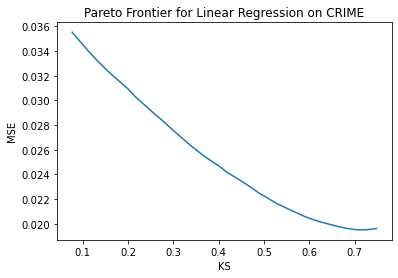

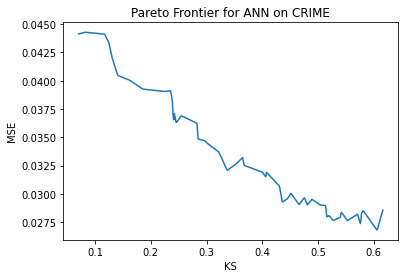

In [66]:
# Pareto frontier plot of linear regression
interploation_model = interp1d(KS_LR, MSE_LR, kind = "linear")
 
X_LR=np.linspace(KS_LR.min(), KS_LR.max(), 500)
Y_LR=interploation_model(X_LR)
 
plt.plot(X_LR, Y_LR)
plt.title("Pareto Frontier for Linear Regression on CRIME")
plt.xlabel("KS")
plt.ylabel("MSE")
plt.show()

# Pareto frontier plot of ANN
interploation_model = interp1d(KS_ANN, MSE_ANN, kind = "linear") 

X_ANN=np.linspace(KS_ANN.min(), KS_ANN.max(), 500)
Y_ANN=interploation_model(X_ANN)
 
plt.plot(X_ANN, Y_ANN)
plt.title("Pareto Frontier for ANN on CRIME")
plt.xlabel("KS")
plt.ylabel("MSE")
plt.show()

## MSE and KS of Linear Regression and ANN via the Post-processing Approach in "Fair Regression with Wasserstein Barycenters" by Chzhen and etc..
We implement the post-processing approach ourselves since the authors of "Fair Regression with Wasserstein Barycenters" did not post their code. See the implementation in "Implementation of Fair Regression with Wasserstein Barycenters.py" and the resulting MSE, KS, and time recording are listed below.

In [67]:
MSE_chzhen_list = [0.036961441313744126,
  0.0353188742578971,
  0.0361223409456084,
  0.035057894309876526,
  0.034046908522304214]
KS_chzhen_list = [0.07714846238120716,
  0.08719227572095402,
  0.14129781925706894,
  0.10272202860233146,
  0.16356936069076244]
time_chzhen_list = [184.98611419300005,
  189.8713959319998,
  177.97821325500036,
  184.2193935360001,
  189.21910878400013]
MSE_chzhen_list_ANN = [0.053348364784510625,
  0.04426087710108407,
  0.04685589840762317,
  0.04448939368760447,
  0.04665935286421082]
KS_chzhen_list_ANN = [0.171978903921119,
  0.12550035168489035,
  0.11927670486046942,
  0.08030284821535873,
  0.08633898433648121]
time_chzhen_list_ANN =  [184.47208375599985,
  183.45621451099942,
  183.45789817400055,
  184.9153239389998,
  185.421339386]

## Generate Figures

In [70]:
# due to the randomness in training ANN, we use the MSE(KS)_origin_list_ANN directly from the MSE(KS)_path_list_ANN to have better visualization
# but one could choose to skip this step and derive similar figures
MSE_origin_list_ANN = np.array(MSE_path_list_ANN)[:,0]
KS_origin_list_ANN = np.array(KS_path_list_ANN)[:,0]
MSE_fair_list_ANN = np.array(MSE_path_list_ANN)[:,49]
KS_fair_list_ANN = np.array(KS_path_list_ANN)[:,49]

# mean and standard deviation of the MSE and KS resulting from the comparison methods:
MSE_origin_mean = np.mean(MSE_origin_list)
MSE_d_mean = np.mean(MSE_d_list)
MSE_fair_mean = np.mean(MSE_fair_list)
MSE_chzhen_mean = np.mean(MSE_chzhen_list)
MSE_origin_std = np.std(MSE_origin_list)
MSE_d_std = np.std(MSE_d_list)
MSE_fair_std = np.std(MSE_fair_list)
MSE_chzhen_std = np.std(MSE_chzhen_list)
KS_origin_mean = np.mean(KS_origin_list)
KS_d_mean = np.mean(KS_d_list)
KS_fair_mean = np.mean(KS_fair_list)
KS_chzhen_mean = np.mean(KS_chzhen_list)
KS_origin_std = np.std(KS_origin_list)
KS_d_std = np.std(KS_d_list)
KS_fair_std = np.std(KS_fair_list)
KS_chzhen_std = np.std(KS_chzhen_list)
MSE_origin_mean_ANN = np.mean(MSE_origin_list_ANN)
MSE_d_mean_ANN = np.mean(MSE_d_list_ANN)
MSE_fair_mean_ANN = np.mean(MSE_fair_list_ANN)
MSE_chzhen_mean_ANN = np.mean(MSE_chzhen_list_ANN)
MSE_origin_std_ANN = np.std(MSE_origin_list_ANN)
MSE_d_std_ANN = np.std(MSE_d_list_ANN)
MSE_fair_std_ANN = np.std(MSE_fair_list_ANN)
MSE_chzhen_std_ANN = np.std(MSE_chzhen_list_ANN)
KS_origin_mean_ANN = np.mean(KS_origin_list_ANN)
KS_d_mean_ANN = np.mean(KS_d_list_ANN)
KS_fair_mean_ANN = np.mean(KS_fair_list_ANN)
KS_chzhen_mean_ANN = np.mean(KS_chzhen_list_ANN)
KS_origin_std_ANN = np.std(KS_origin_list_ANN)
KS_d_std_ANN = np.std(KS_d_list_ANN)
KS_fair_std_ANN = np.std(KS_fair_list_ANN)
KS_chzhen_std_ANN = np.std(KS_chzhen_list_ANN)

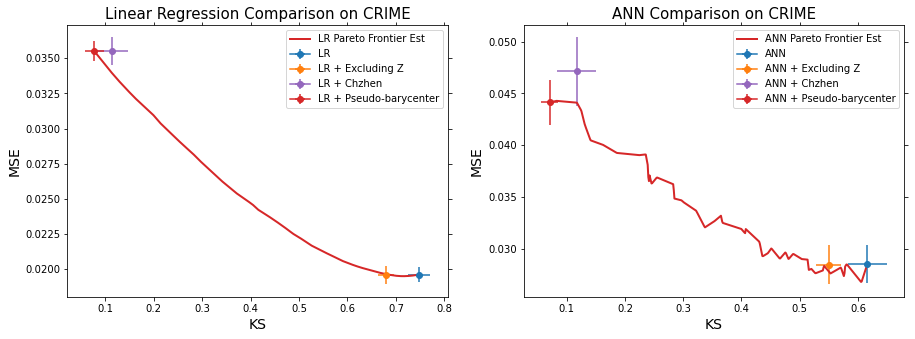

In [71]:
# Generate Figure
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].errorbar(KS_origin_mean, MSE_origin_mean, xerr=KS_origin_std, yerr=MSE_origin_std, fmt='-o') # LR
axs[0].errorbar(KS_d_mean, MSE_d_mean, xerr=KS_d_std, yerr=MSE_d_std, fmt='-o') # LR + Excluding Z
axs[0].errorbar(KS_chzhen_mean, MSE_chzhen_mean, xerr=KS_chzhen_std, yerr=MSE_chzhen_std, fmt='-o',color = '#9467bd') # LR + chzhen
axs[0].errorbar(KS_fair_mean, MSE_fair_mean, xerr=KS_fair_std, yerr=MSE_fair_std, fmt='-o',color = '#d62728') # LR + pseudo-barycenter
axs[0].plot(X_LR,Y_LR,linewidth = 2, color = '#d62728')

axs[0].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[0].legend(['LR Pareto Frontier Est','LR','LR + Excluding Z','LR + Chzhen','LR + Pseudo-barycenter'], 
           loc='best',fancybox=True)

axs[0].set_ylabel('MSE', fontsize=14)
axs[0].set_xlabel('KS', fontsize=14)
axs[0].set_title(f"Linear Regression Comparison on CRIME", fontsize=15)
#axs[0].set_ylim(0.76, 0.825)
#axs[1].set_xlim(-0.2, 1)


axs[1].errorbar(KS_origin_mean_ANN, MSE_origin_mean_ANN, xerr=KS_origin_std_ANN, yerr=MSE_origin_std_ANN, fmt='-o') # ANN
axs[1].errorbar(KS_d_mean_ANN, MSE_d_mean_ANN, xerr=KS_d_std_ANN, yerr=MSE_d_std_ANN, fmt='-o') # ANN + Excluding Z
axs[1].errorbar(KS_chzhen_mean_ANN, MSE_chzhen_mean_ANN, xerr=KS_chzhen_std_ANN, yerr=MSE_chzhen_std_ANN, fmt='-o',color = '#9467bd') # ANN + chzhen
axs[1].errorbar(KS_fair_mean_ANN, MSE_fair_mean_ANN, xerr=KS_fair_std_ANN, yerr=MSE_fair_std_ANN, fmt='-o',color = '#d62728') # ANN + pseudo-barycenter
axs[1].plot(X_ANN,Y_ANN,linewidth = 2, color = '#d62728')

#fig.axes.get_xaxis().set_visible(False)

axs[1].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[1].legend(['ANN Pareto Frontier Est','ANN','ANN + Excluding Z','ANN + Chzhen','ANN + Pseudo-barycenter'], 
           loc='best',fancybox=True)

axs[1].set_ylabel('MSE', fontsize=14)
axs[1].set_xlabel('KS', fontsize=14)
axs[1].set_title(f"ANN Comparison on CRIME", fontsize=15)
#axs[1].set_ylim(1.2, 1.6)
#axs[1].set_xlim(-0.2, 1)

fig.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig('Pareto Frontier CRIME', dpi=400,bbox_inches='tight')